# Exploratory Data Analysis

Step 1: Clean data

In [1]:
# imports
import pandas as pd

In [2]:
# import data
data = pd.read_json('logins.json')

In [3]:
data.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

In [4]:
# sort logins in chronological order
data=data.sort_values(by='login_time')
data=data.reset_index()
data=data.drop(columns=['index'])

In [5]:
# review chronological data
data

login_time
0     1970-01-01 20:12:16
1     1970-01-01 20:13:18
2     1970-01-01 20:16:10
3     1970-01-01 20:16:36
4     1970-01-01 20:16:37
...                   ...
93137 1970-04-13 18:48:52
93138 1970-04-13 18:50:19
93139 1970-04-13 18:54:02
93140 1970-04-13 18:54:23
93141 1970-04-13 18:57:38

[93142 rows x 1 columns]

The logins start in January 1, 1970 around 8 PM and end in April 13, 1970 around 7 PM. 

In [6]:
# check if there are any null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [7]:
data.login_time.unique

<bound method Series.unique of 0       1970-01-01 20:12:16
1       1970-01-01 20:13:18
2       1970-01-01 20:16:10
3       1970-01-01 20:16:36
4       1970-01-01 20:16:37
                ...        
93137   1970-04-13 18:48:52
93138   1970-04-13 18:50:19
93139   1970-04-13 18:54:02
93140   1970-04-13 18:54:23
93141   1970-04-13 18:57:38
Name: login_time, Length: 93142, dtype: datetime64[ns]>

The unique method on the login_time column of data lets us know that there are 93,142 unique entries. This information, combined with the data.info() result of 93,142 non-null entries, implies that there are no duplicates. 

Step 2: Aggregate these login counts based on 15 minute time intervals

In [8]:
data['count'] = 1
data.head()

login_time  count
0 1970-01-01 20:12:16      1
1 1970-01-01 20:13:18      1
2 1970-01-01 20:16:10      1
3 1970-01-01 20:16:36      1
4 1970-01-01 20:16:37      1

In [9]:
custom_df = data.groupby(pd.Grouper(key='login_time', freq='15min')).sum()

In [10]:
custom_df

count
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1
...                    ...
1970-04-13 17:45:00      5
1970-04-13 18:00:00      5
1970-04-13 18:15:00      2
1970-04-13 18:30:00      7
1970-04-13 18:45:00      6

[9788 rows x 1 columns]

In [11]:
custom_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


In [12]:
custom_df['count'].sum()

93142

In [13]:
custom_df.describe()

count
count  9788.000000
mean      9.515938
std       8.328818
min       0.000000
25%       3.000000
50%       7.000000
75%      13.000000
max      73.000000

The mean login count is approximately 9.5 and the median is 7. This difference in values indicates that there are  high values that are positively skewing the mean. (This data is right skewed.)

Step 3: Visualizations

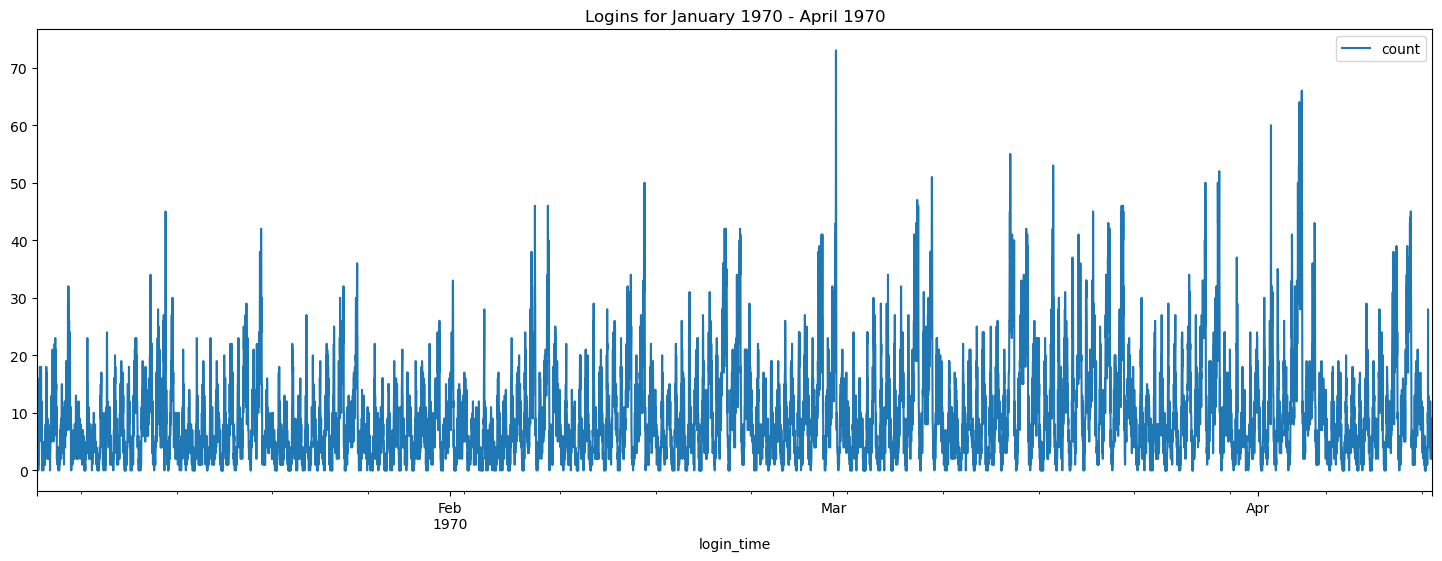

In [14]:
# visualize entire data
import matplotlib.pyplot as plt
import seaborn as sns

custom_df.plot(figsize=(18,6))
plt.title('Logins for January 1970 - April 1970')
plt.show()

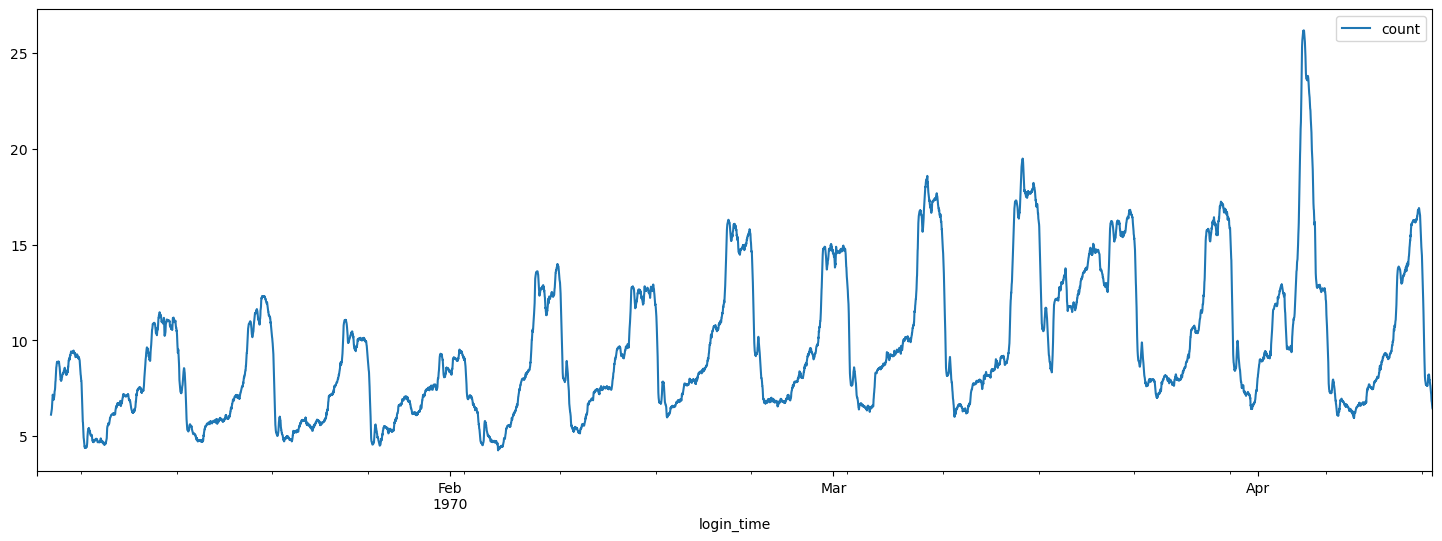

In [15]:
custom_df.rolling(window=96).mean().plot(figsize=(18,6))
plt.show()

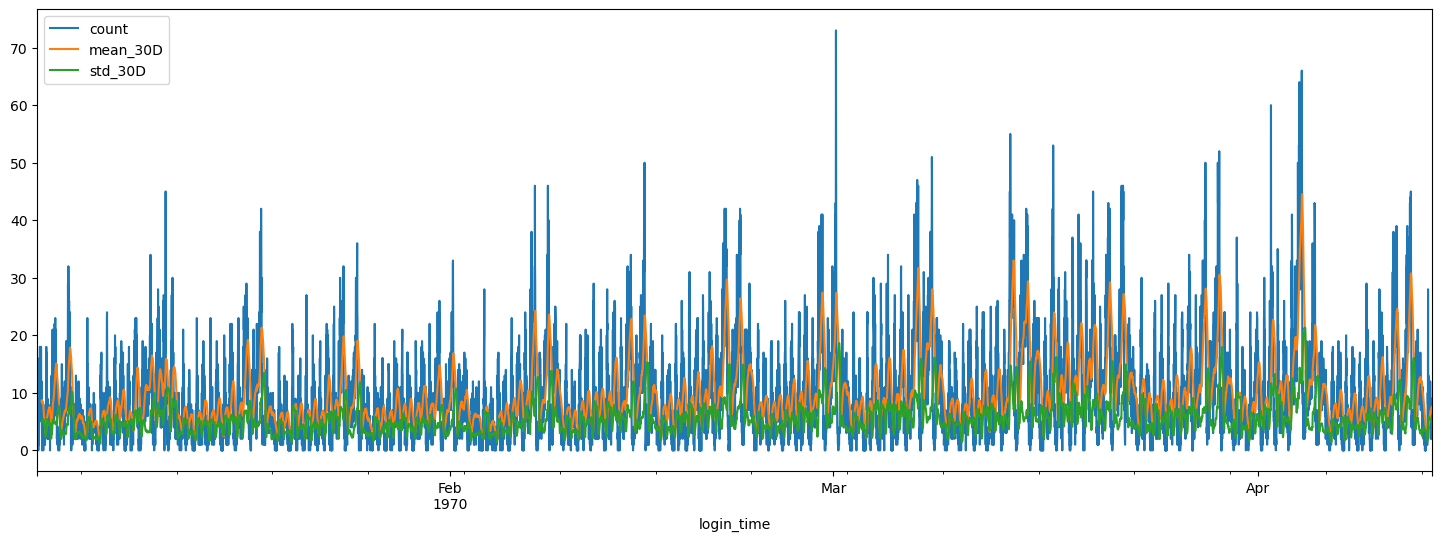

In [16]:
rolling_stats = custom_df['count'].rolling(window=30).agg(['mean', 'std']).rename(columns={'mean': 'mean_30D', 'std': 'std_30D'})

# join custom_df aka login aggregate info with rolling_stats
stats = custom_df.join(rolling_stats)
stats.plot(figsize=(18,6))
plt.show()


Overall, it looks like the general trend is increasing because the mean login counts are gradually increasing as time increases. There also appears to be a weekly trend with peaks during the weekend. This will be investigated further below.

In [17]:
import numpy as np

[Timestamp('1970-01-05 00:00:00'), Timestamp('1970-01-18 00:00:00'), Timestamp('1970-01-21 00:00:00'), Timestamp('1970-02-13 00:00:00'), Timestamp('1970-03-02 00:00:00')]


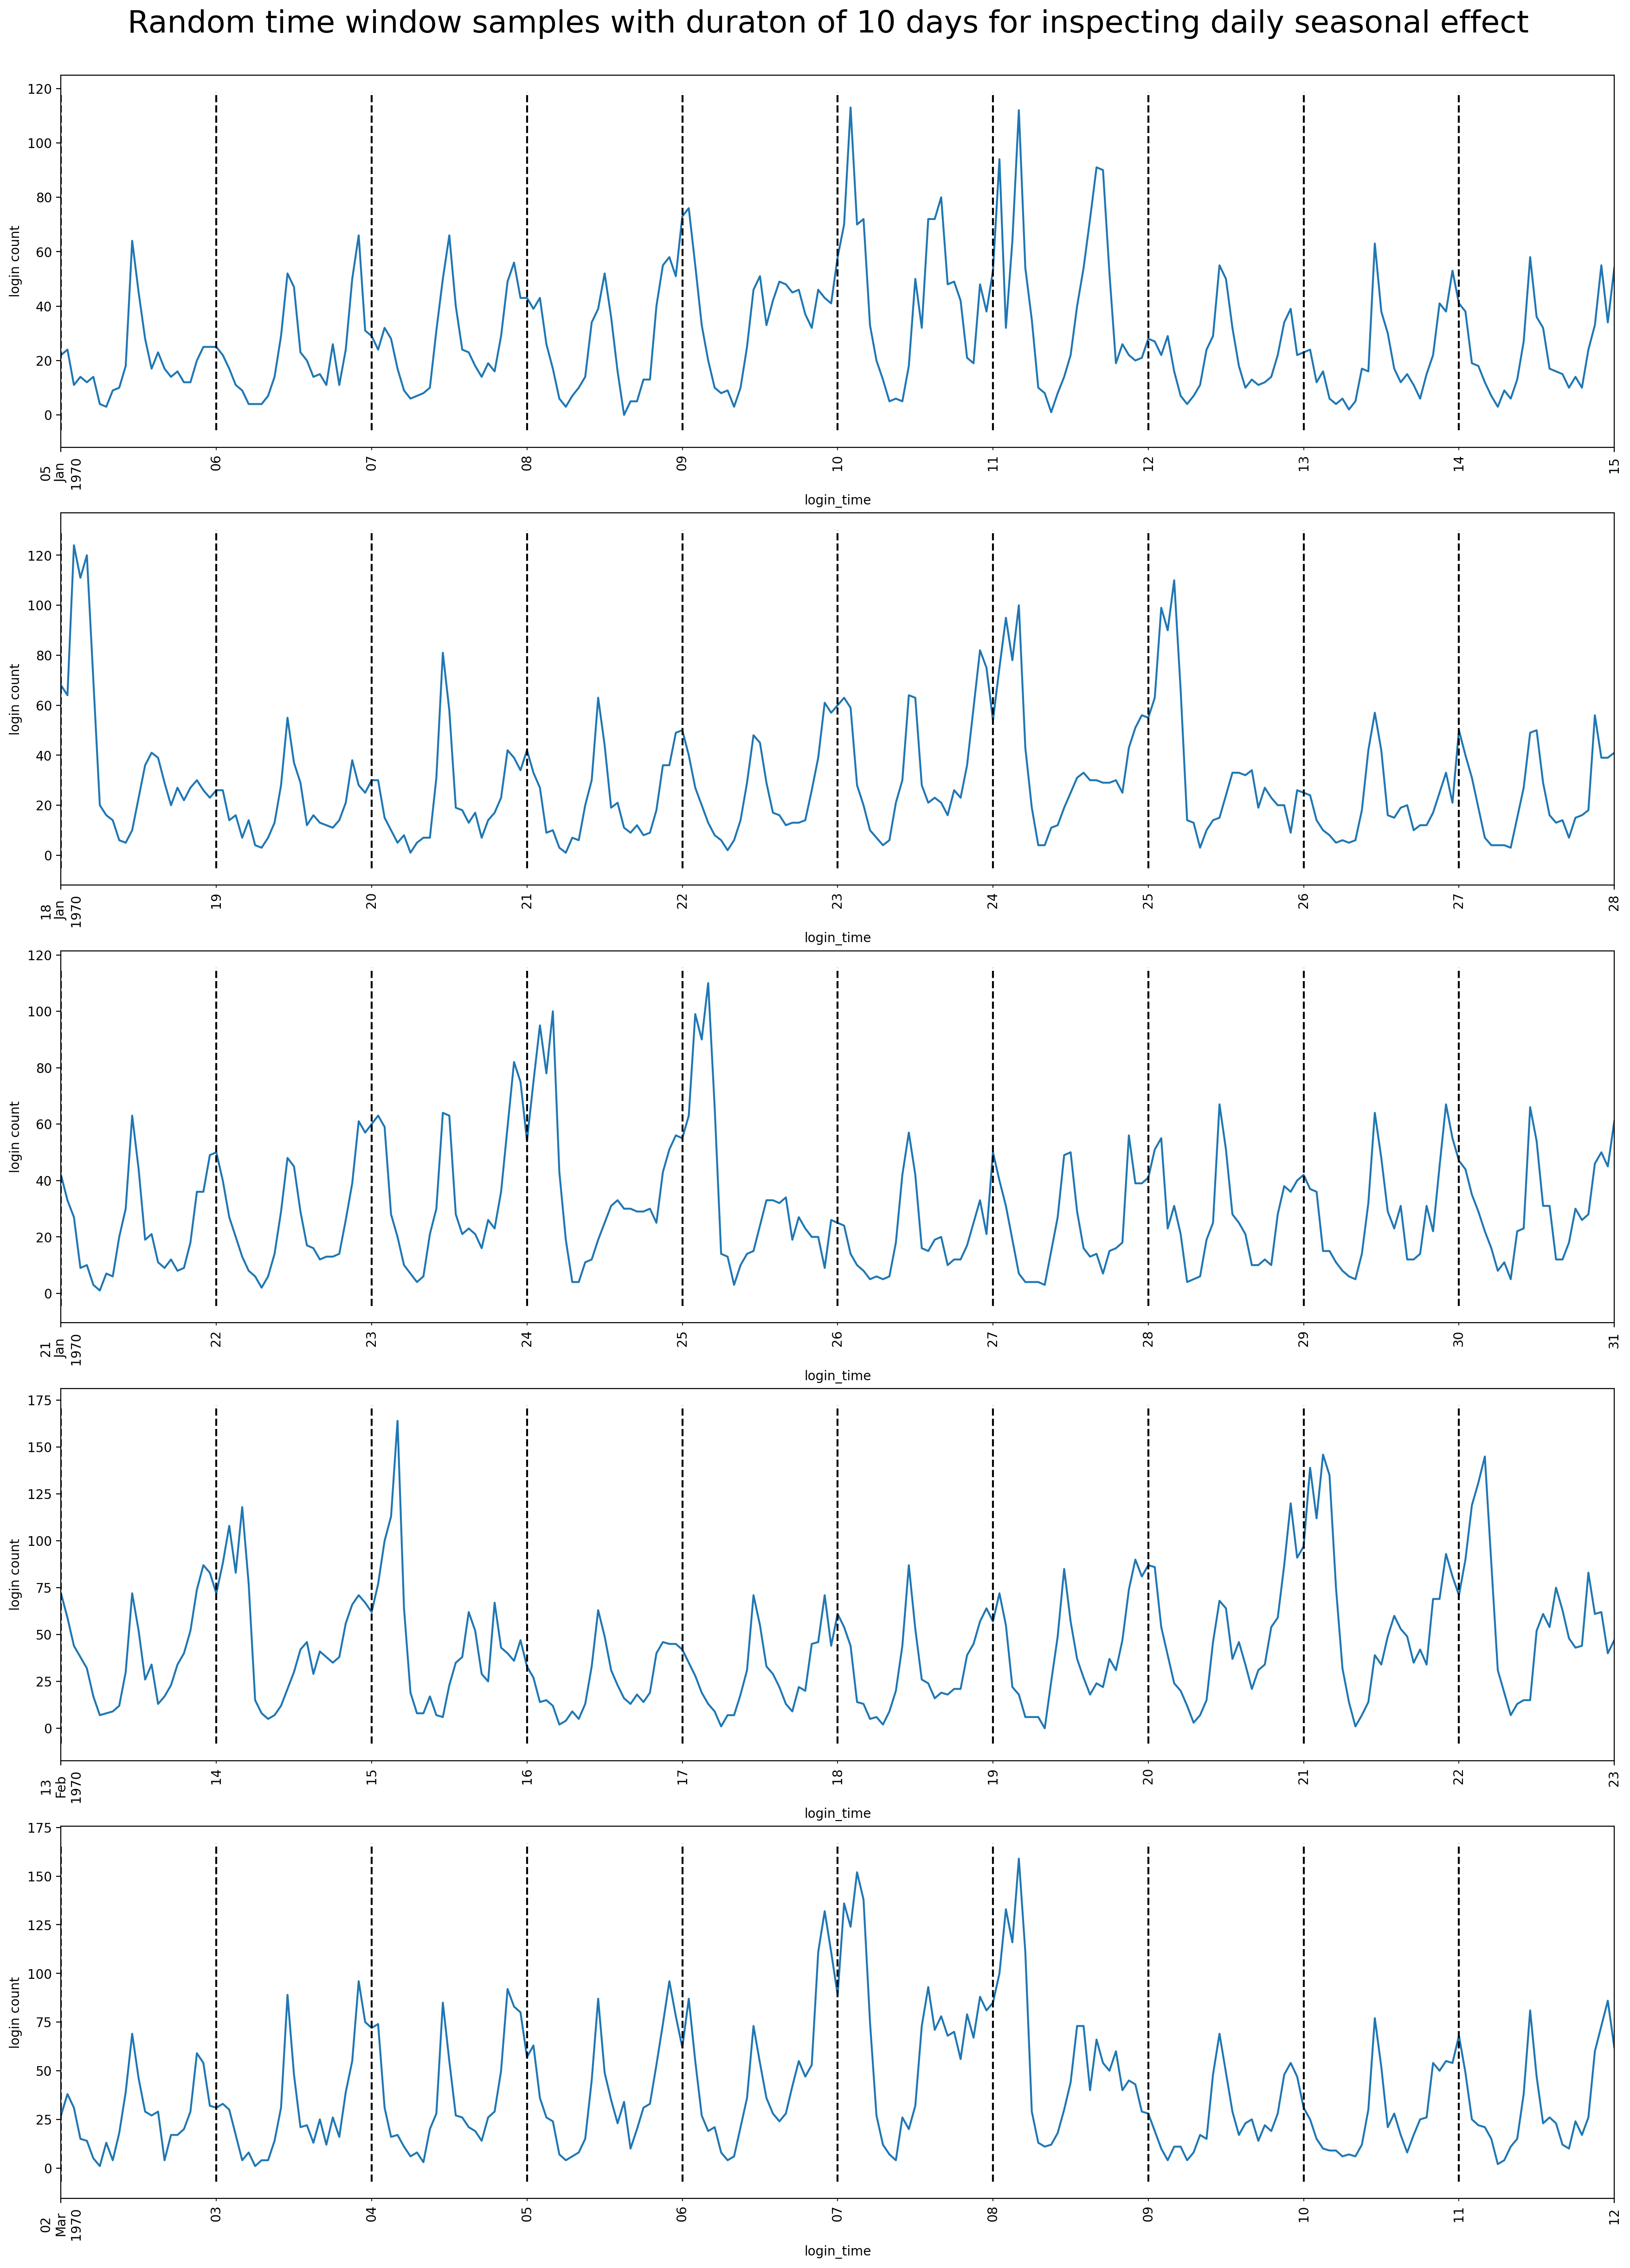

In [18]:
hourly_df = data.groupby(pd.Grouper(key='login_time', freq='1h')).sum()
#drawing a random sample of 5 indices without repetition from sub sample, where current time is 04:00
sample = sorted([x for x in np.random.choice([x for x in hourly_df.index[:-241] if x.hour == 0],5,replace=False)])
print(sample)
#checking persistence of daily seasonality by inspecting 5 random time window of 10 days
f, axes = plt.subplots(len(sample),1,dpi=200,figsize=(18,24));
f.tight_layout(pad=3.0)
plt.suptitle('Random time window samples with duraton of 10 days for inspecting daily seasonal effect', y = 1.01, fontsize=24)

#plotting time windows and drawing vertical lines at 00:00 each day
for si,s in enumerate(sample):
    ids = hourly_df.index.to_list().index(s)
    idx = [hourly_df.iloc[x:x+1,:].index.values for x in range(ids, ids + 240,24)]
    hourly_df.iloc[ids:(ids+241),:].plot(ax=axes[si], legend=False, rot=90, ylabel='login count');
    axes[si].vlines(idx, axes[si].get_ylim()[0], axes[si].get_ylim()[1], colors='black', linestyles='dashed')

Each black line represents 12:00 AM.  Almost every day appears to begin with a decline and has a peak in middle as well as towards the end of the day. This indicates there may be some daily seasonality at midnight and noon.

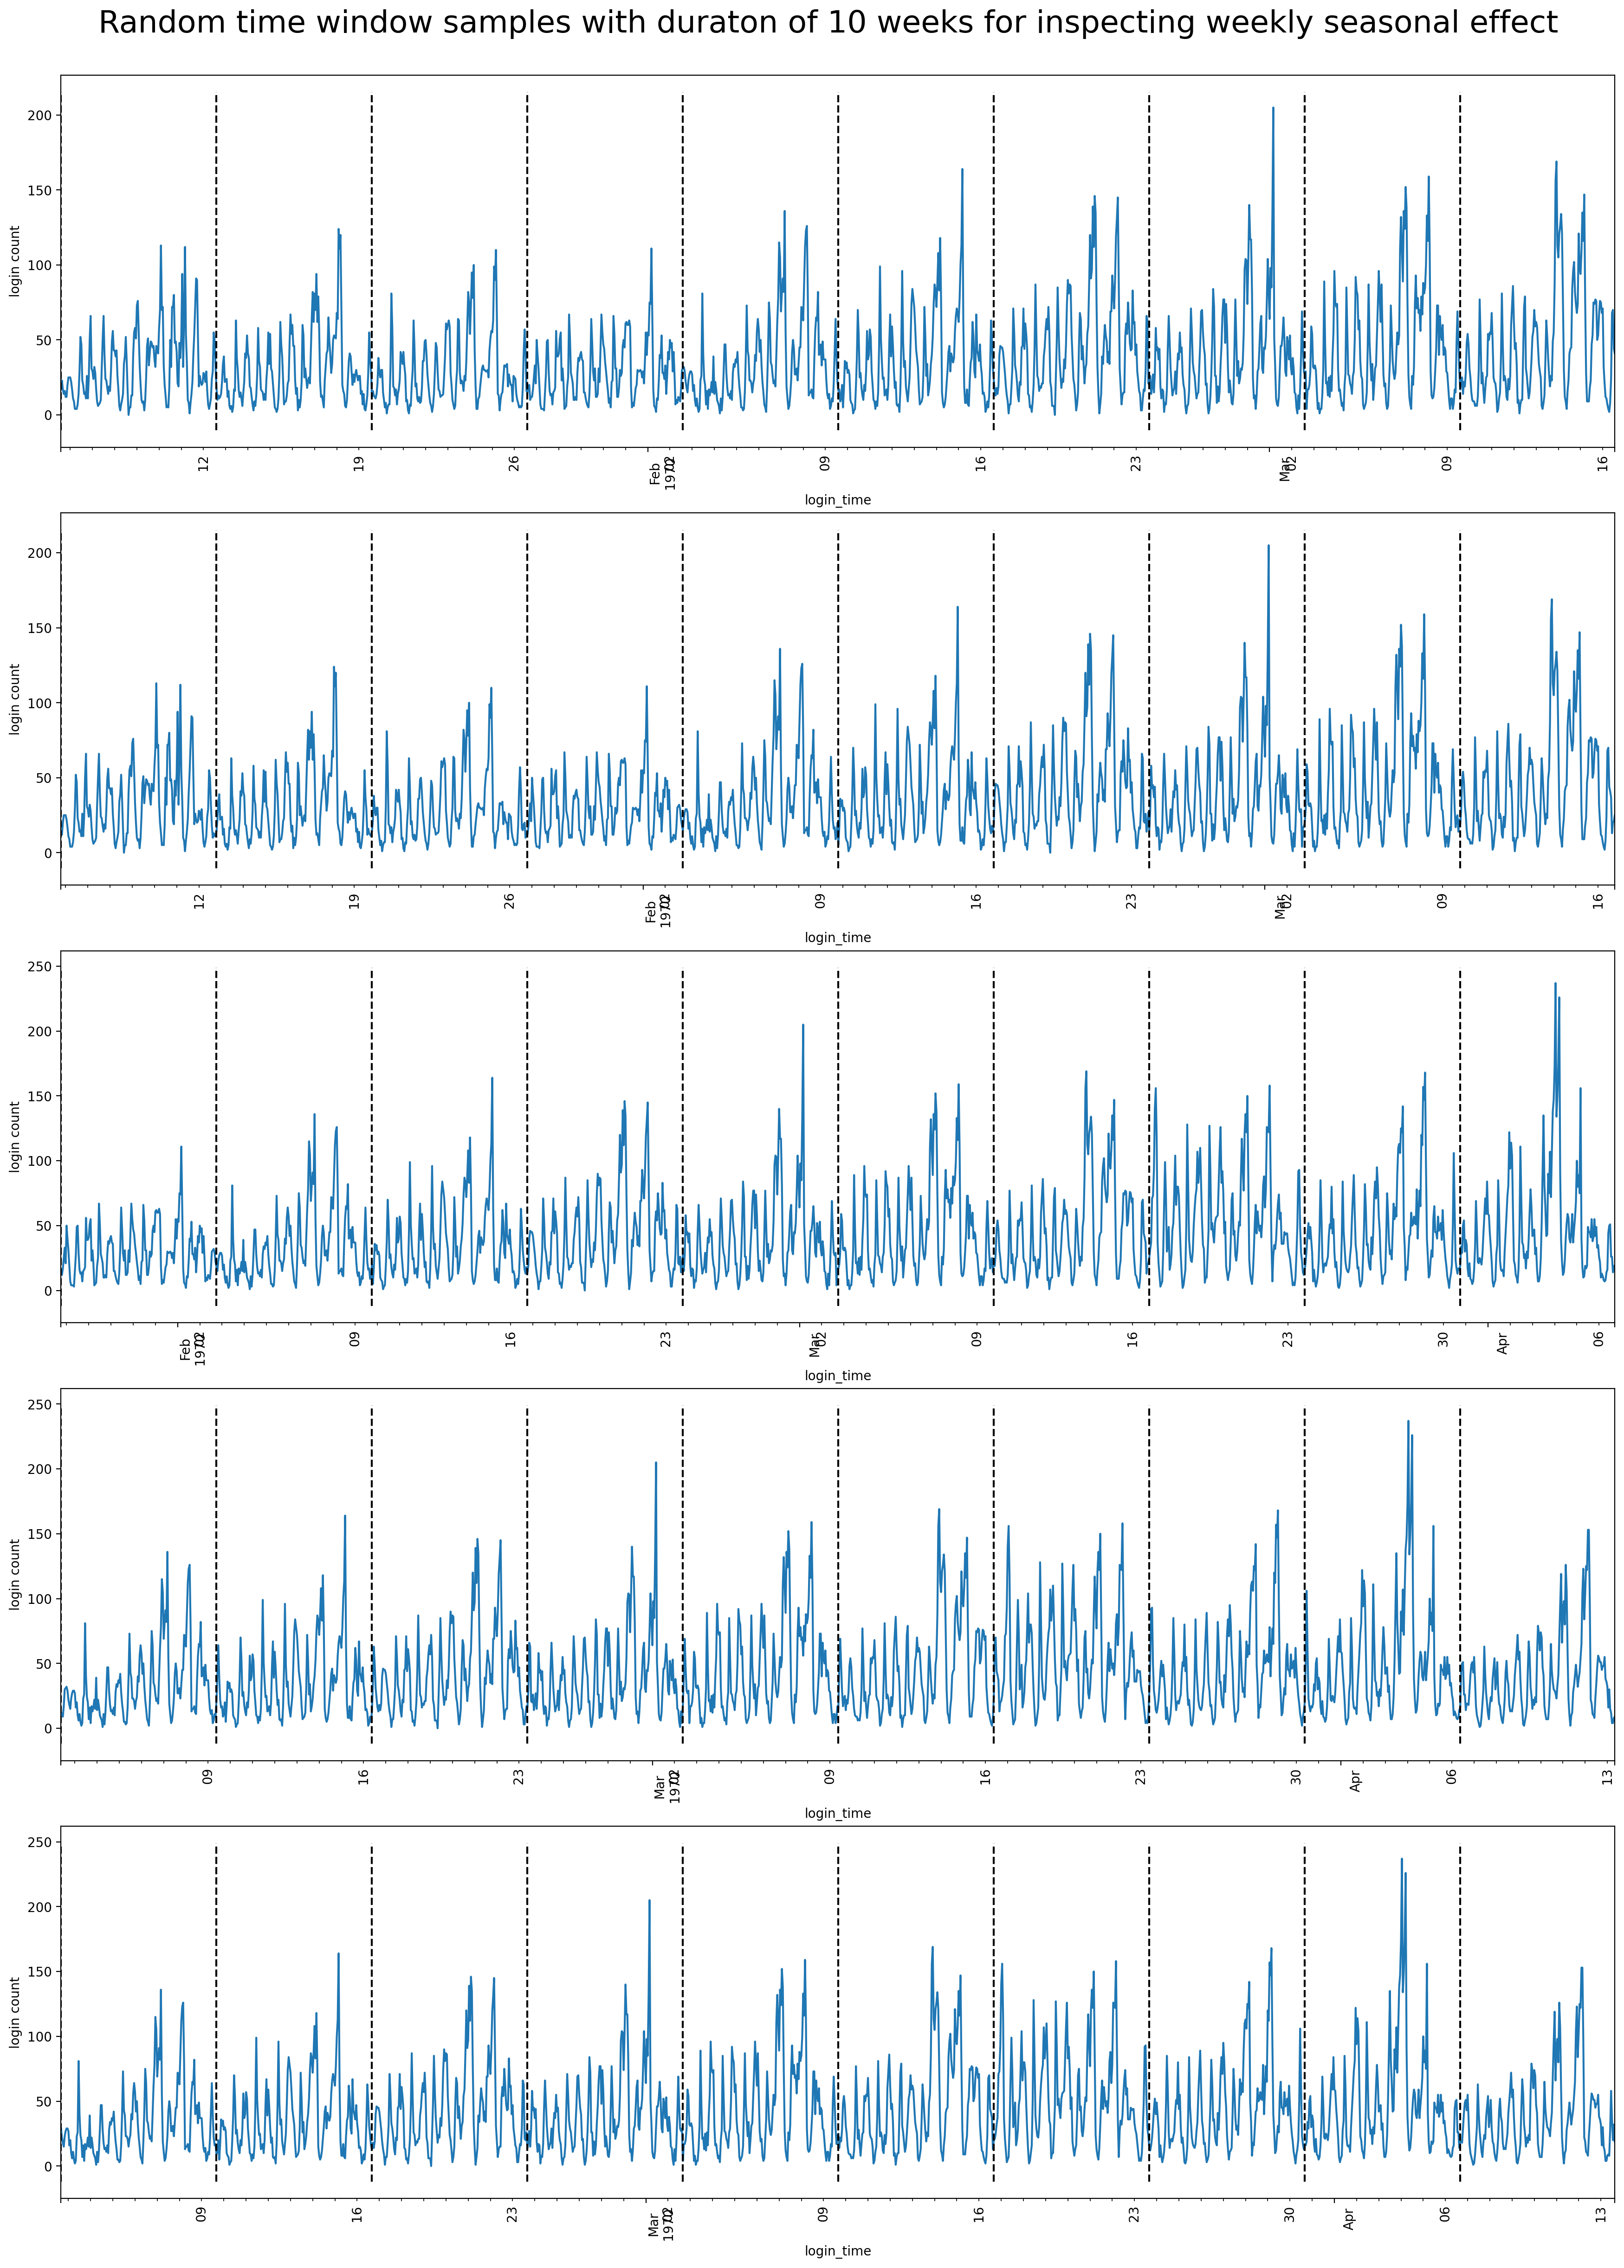

In [19]:
#drawing a random sample of 5 indices without repetition from sub sample of Mondays
sample = sorted([x for x in np.random.choice([x for x in hourly_df.index[:-1680] if x.dayofweek == 0],5,replace=False)])
#checking persistence of weekly seasonality by inspecting 5 random time window of 10 days
f, axes = plt.subplots(len(sample),1,dpi=200,figsize=(18,24));
f.tight_layout(pad=3.0)
plt.suptitle('Random time window samples with duraton of 10 weeks for inspecting weekly seasonal effect', y = 1.01, fontsize=24)

#plotting time windows and drawing vertical lines at every Monday
for si,s in enumerate(sample):
    ids = hourly_df.index.to_list().index(s)
    idx = [hourly_df.iloc[x:x+1,:].index.values for x in range(ids, ids + 1680,168)]
    hourly_df.iloc[ids:(ids+1680),:].plot(ax=axes[si], legend=False, rot=90, ylabel='login count');
    axes[si].vlines(idx, axes[si].get_ylim()[0], axes[si].get_ylim()[1], colors='black', linestyles='dashed')

In each graph of random 10 week duration samples there is a clear peak on the weekends. This confirms the initial observation of weekly seasonality.

# Final Observations

1. There is an overall increasing trend. The average is increasing and peaks in March.
2. There is weekly seasonality. The weekends have higher login counts than weekdays.
3. There is seasonality in times of day. Midnight and midday are peak login times.